# Short-Time Fourier Transform (STFT): why it exists, what it’s used for, and why window size matters

## What is STFT?
The **Short-Time Fourier Transform (STFT)** is a time–frequency analysis tool that extends the FFT to **non‑stationary signals**—signals whose frequency content changes over time (speech, vibration, acoustic emission, machine transients, melt-pool instabilities, etc.).  
Instead of analyzing the *entire* signal in one shot, STFT analyzes **short, sliding segments** (windows) and computes a Fourier transform for each segment. The result is a **2D map** (time × frequency) that shows *when* different frequency components occur.

## What is STFT used for?
STFT is used whenever you care about **both**:
- **Which frequencies are present** and
- **When they occur**

Common practical use-cases:
- Transient detection (bursts, impacts, crack/AE events, tool chatter)
- Process monitoring (regime changes, instabilities, anomalies)
- Speech/music analysis (phonemes, onsets, timbre)
- Diagnostics in rotating machinery (fault harmonics appearing intermittently)
- Any signal with **time-varying spectral content**

## Why plain FFT is often insufficient (the disadvantage)
The FFT assumes you’re analyzing a **stationary** signal over the whole record. It returns a spectrum that is an **average over time**:
- If a 350 Hz tone appears only briefly, the FFT shows *it exists*, but not **when** it happened.
- If the signal changes from 100 Hz to a chirp, the FFT blends it into a single global summary.

So: **FFT is great for “what frequencies exist overall,” but it cannot tell “when they happen.”**  
That missing time information is exactly what STFT restores.

## The STFT equation
A common discrete-time STFT definition is:

$$
X(m,\omega) = \sum_{n=-\infty}^{\infty} x[n]\; w[n-m]\; e^{-j\omega n}
$$

Where:
- $x[n]$ is the signal
- $w[\cdot]$ is the window function (e.g., Hann/Hamming)
- $m$ is the time index (window position / frame)
- $\omega$ is angular frequency

In plain language: **multiply by a shifted window, then FFT that chunk**.

## Why window size is *the* main knob
Window size controls the classic trade-off:

- **Short window** → good **time resolution**, poor **frequency resolution**  
  (events are localized in time, frequency bins look smeared / thick)
- **Long window** → good **frequency resolution**, poor **time resolution**  
  (harmonics are sharp in frequency, but events smear across time)

Useful rules of thumb:
- Time resolution $\approx$ window duration $= N_{\text{win}}/f_s$
- Frequency bin spacing $\Delta f \approx f_s/N_{\text{win}}$

So window size is important because it decides what your plot will “tell the truth” about: **timing** or **spectral precision**.


## Demo: effect of window size (separate plots)
We generate a signal with:
- a 100 Hz tone early
- a 350 Hz tone in the middle
- a chirp (200→700 Hz) later

Then we compute STFT with different window sizes and show **separate 2D spectrograms** (one figure per window size) using a **shared dB color scale** so the comparison is fair.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, get_window, chirp

In [3]:
# -----------------------------
# 1) Make a signal with time-varying frequency content
# -----------------------------
fs = 2000  # Hz
T = 2.0    # seconds
t = np.arange(int(T * fs)) / fs

x1 = (t < 0.8) * np.sin(2*np.pi*100*t)  # 100 Hz early
x2 = ((t >= 0.8) & (t < 1.3)) * 0.9*np.sin(2*np.pi*350*t)  # 350 Hz mid
x3 = (t >= 1.3) * 0.8*chirp(t, f0=200, f1=700, t1=T, method="linear")  # chirp late

rng = np.random.default_rng(0)
x = x1 + x2 + x3 + 0.05*rng.standard_normal(len(t))

In [4]:
# -----------------------------
# 2) Helper to compute STFT (single call)
# -----------------------------
def compute_stft_db(x, fs, nperseg, overlap_ratio=0.75, window_type="hann"):
    noverlap = int(overlap_ratio * nperseg)
    win = get_window(window_type, nperseg, fftbins=True)
    f, tt, Zxx = stft(
        x, fs=fs, window=win,
        nperseg=nperseg, noverlap=noverlap,
        nfft=nperseg, boundary=None, padded=False
    )
    S_db = 20*np.log10(np.abs(Zxx) + 1e-12)
    return f, tt, S_db

In [5]:
# -----------------------------
# 3) Compute STFTs (for shared color scaling)
# -----------------------------
f64,  tt64,  S64  = compute_stft_db(x, fs, nperseg=64)
f256, tt256, S256 = compute_stft_db(x, fs, nperseg=256)
f1024, tt1024, S1024 = compute_stft_db(x, fs, nperseg=1024)

all_db = np.hstack([S64.ravel(), S256.ravel(), S1024.ravel()])
vmax = np.percentile(all_db, 99)
vmin = vmax - 60  # show 60 dB range

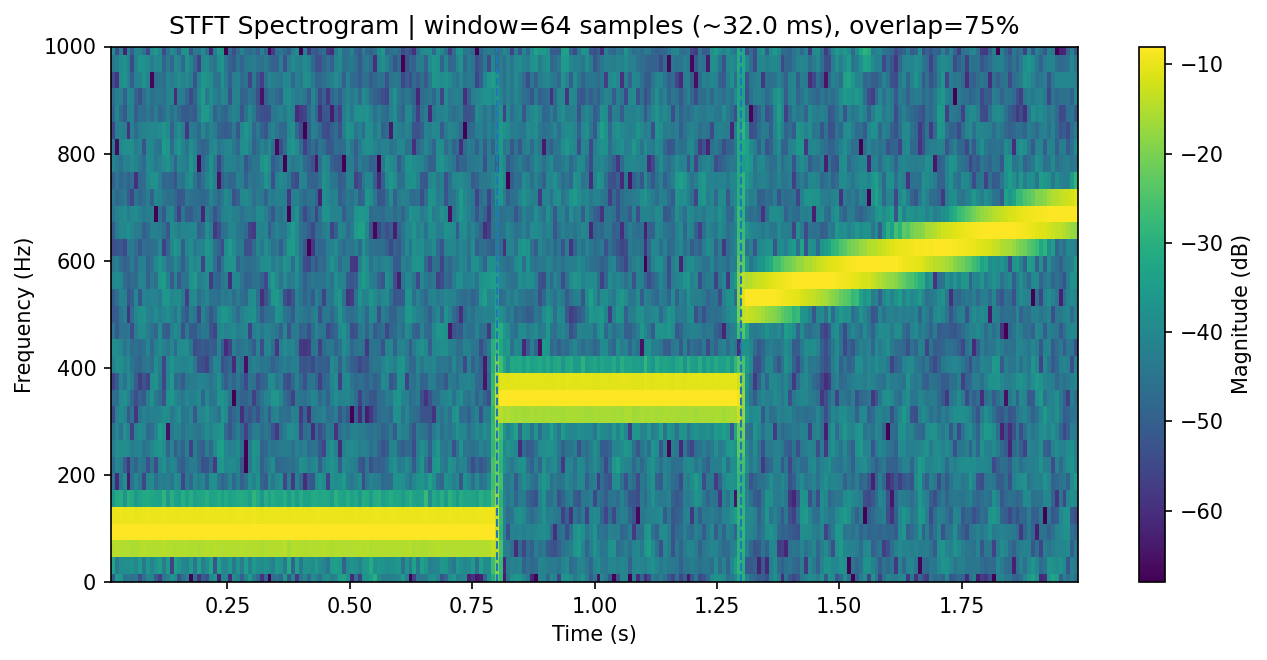

In [6]:
# ============================================================
# PLOT 1: window = 64
# ============================================================
plt.figure(figsize=(9, 4.5), dpi=150)
im = plt.pcolormesh(tt64, f64, S64, shading="auto", vmin=vmin, vmax=vmax)
plt.title(f"STFT Spectrogram | window=64 samples (~{64/fs*1000:.1f} ms), overlap=75%")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, fs/2)
plt.axvline(0.8, linestyle="--", linewidth=1)
plt.axvline(1.3, linestyle="--", linewidth=1)
cbar = plt.colorbar(im); cbar.set_label("Magnitude (dB)")
plt.tight_layout()
plt.show()

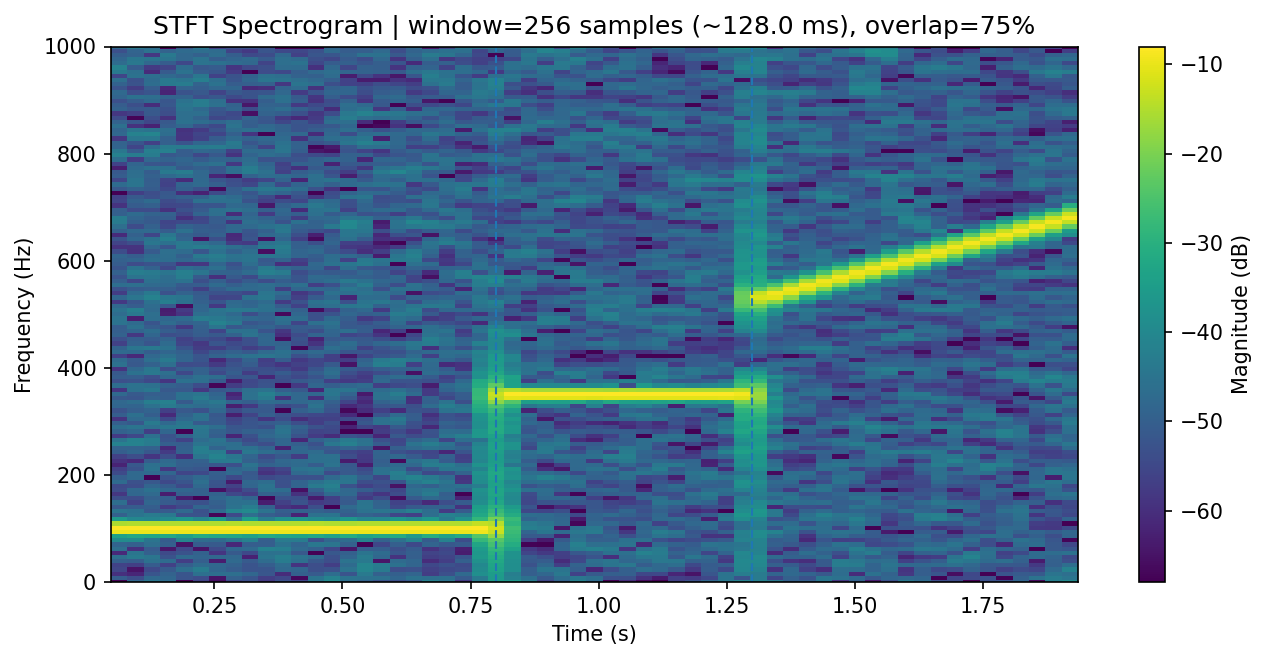

In [7]:
# ============================================================
# PLOT 2: window = 256
# ============================================================
plt.figure(figsize=(9, 4.5), dpi=150)
im = plt.pcolormesh(tt256, f256, S256, shading="auto", vmin=vmin, vmax=vmax)
plt.title(f"STFT Spectrogram | window=256 samples (~{256/fs*1000:.1f} ms), overlap=75%")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, fs/2)
plt.axvline(0.8, linestyle="--", linewidth=1)
plt.axvline(1.3, linestyle="--", linewidth=1)
cbar = plt.colorbar(im); cbar.set_label("Magnitude (dB)")
plt.tight_layout()
plt.show()

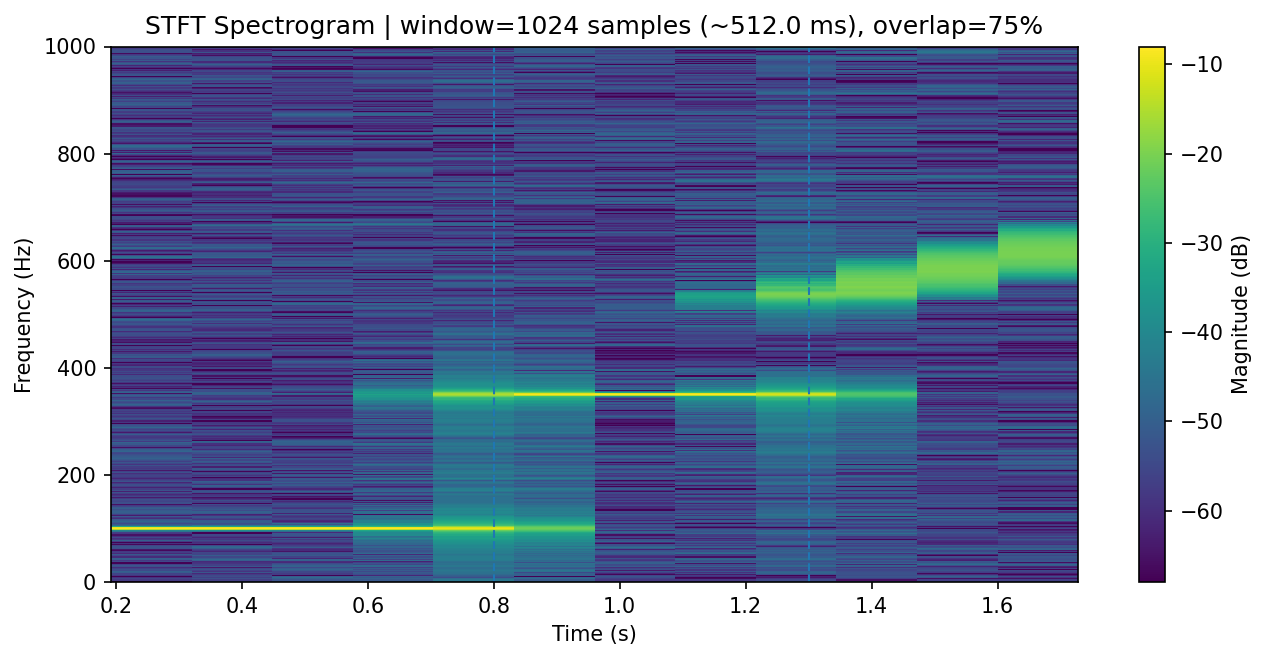

Done. Compare: short window = better timing / worse frequency; long window = better frequency / worse timing.


In [8]:
# ============================================================
# PLOT 3: window = 1024
# ============================================================
plt.figure(figsize=(9, 4.5), dpi=150)
im = plt.pcolormesh(tt1024, f1024, S1024, shading="auto", vmin=vmin, vmax=vmax)
plt.title(f"STFT Spectrogram | window=1024 samples (~{1024/fs*1000:.1f} ms), overlap=75%")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, fs/2)
plt.axvline(0.8, linestyle="--", linewidth=1)
plt.axvline(1.3, linestyle="--", linewidth=1)
cbar = plt.colorbar(im); cbar.set_label("Magnitude (dB)")
plt.tight_layout()
plt.show()

print("Done. Compare: short window = better timing / worse frequency; long window = better frequency / worse timing.")